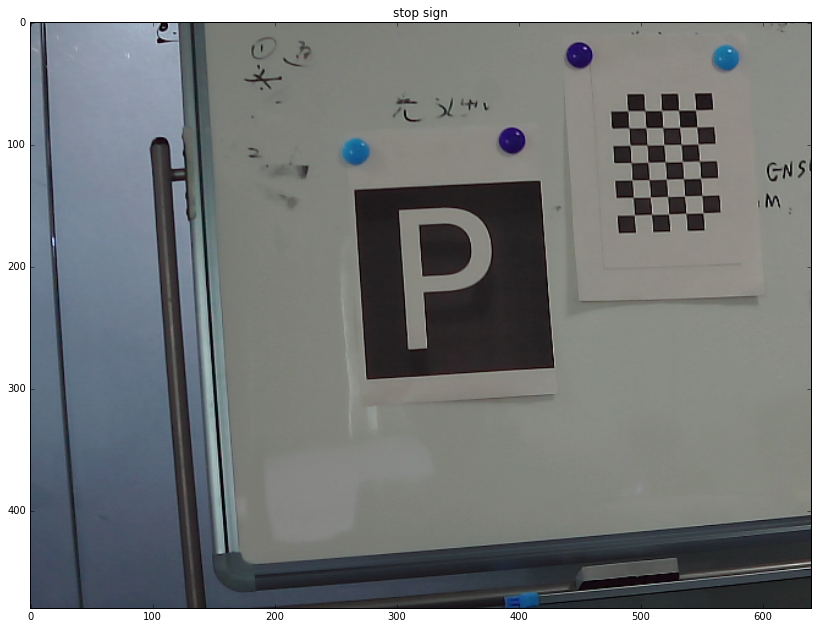

In [1]:
import cv2
import numpy as np
import time
import glob
import matplotlib.pyplot as plt
from numpy import *
%matplotlib inline

# load pretrained stop sign cascade detector
stop_sign = cv2.CascadeClassifier('cascade.xml')

# load and show test image
images = glob.glob('images/*.png')
img = cv2.imread('images/calibresult_1.png')
frame = cv2.imread('images/calibresult_1.png')
plt.figure(figsize=(14,14))
plt.imshow(img)
plt.title('stop sign')

Stop sign detected


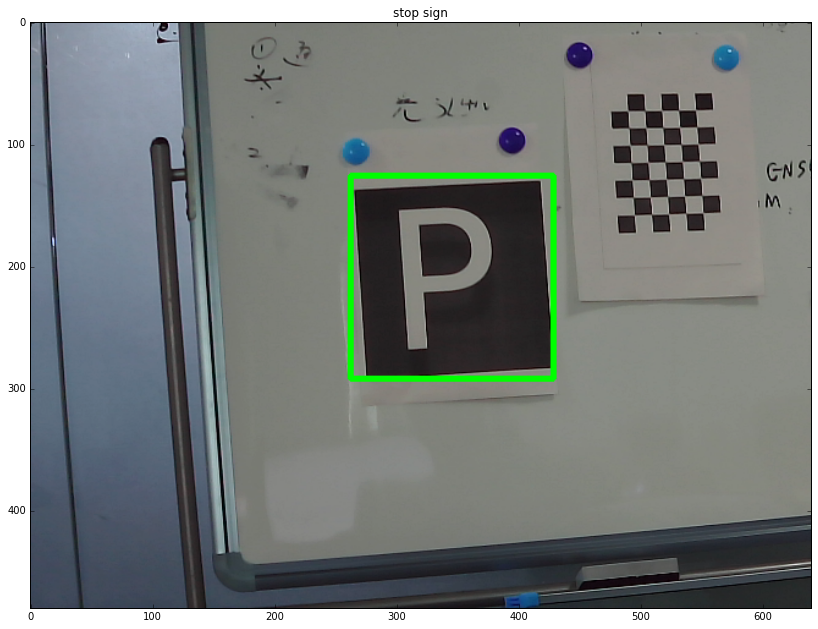

In [2]:
# convert bgr to gray
gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
# stop sign cascade detector
stops = stop_sign.detectMultiScale(frame,scaleFactor=1.1,
                                   minNeighbors=1,
                                   minSize=(100, 100))
expend = 20
# if detect stop sign
if len(stops)!=0:
    print "Stop sign detected"
    for (x,y,w,h) in stops:
        roi = img[y-expend:y+h+expend,x-expend:x+w+expend]
        rect = gray[y-expend:y+h+expend,x-expend:x+w+expend]
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),3)
plt.figure(figsize=(14,14))
plt.imshow(img)
plt.title('stop sign')

Overlap point detected, removed success
Overlap point detected, removed success
Overlap point detected, removed success
Overlap point detected, removed success
Overlap point detected, removed success
Overlap point detected, removed success
Overlap point detected, removed success
Overlap point detected, removed success
Overlap point detected, removed success
Overlap point detected, removed success
Overlap point detected, removed success
Overlap point detected, removed success
Overlap point detected, removed success
Overlap point detected, removed success
Overlap point detected, removed success
Overlap point detected, removed success
Overlap point detected, removed success
11 corner points reserved.


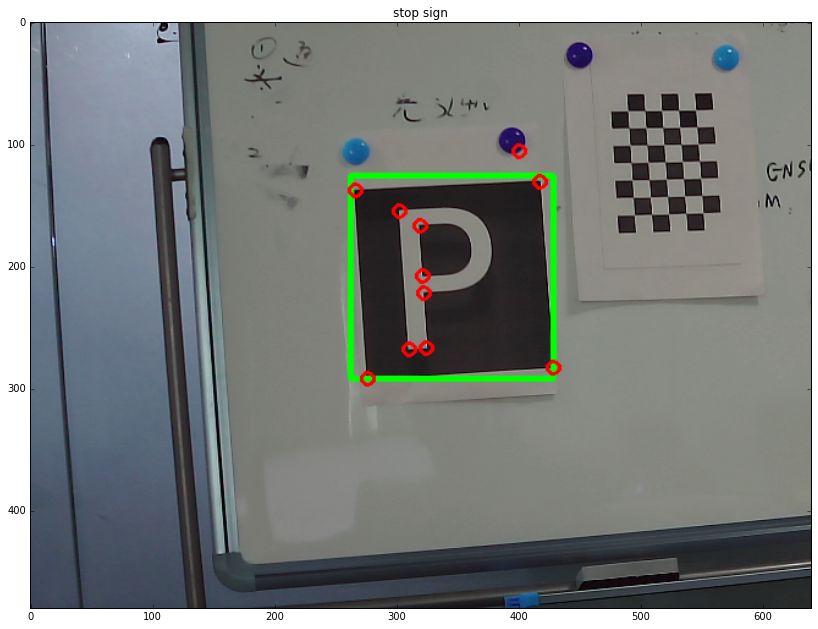

In [3]:
# find Harris corners
# blocksize = 2
# ksize = 3
# k = 0.05
dst =cv2.cornerHarris(rect,2,3,0.05)
tf_table=dst>0.05*dst.max()

corners=[]
cid=0
for r in range(h+2*expend):
    for c in range(w+2*expend):
        if tf_table[r,c]:
            remove = True
            pts = (x+c-expend,y+r-expend)
            for corner in corners:
                if np.linalg.norm(mat(pts)-mat(corner))<3:
                    remove=False
                    print("Overlap point detected, removed success")
            if remove:
                corners.append(pts)
                cid+=1
                cv2.circle(img,pts,5,(255,0,0),2)

print("%d corner points reserved." %len(corners))
plt.figure(figsize=(14,14))
plt.imshow(img)
plt.title('stop sign')

Found the boundary


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app


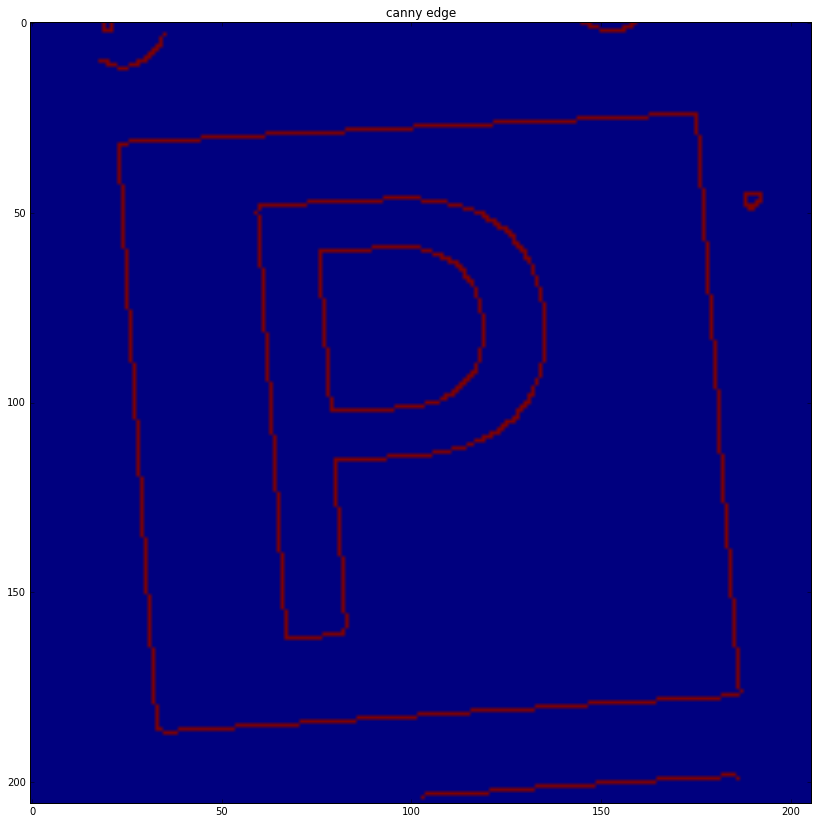

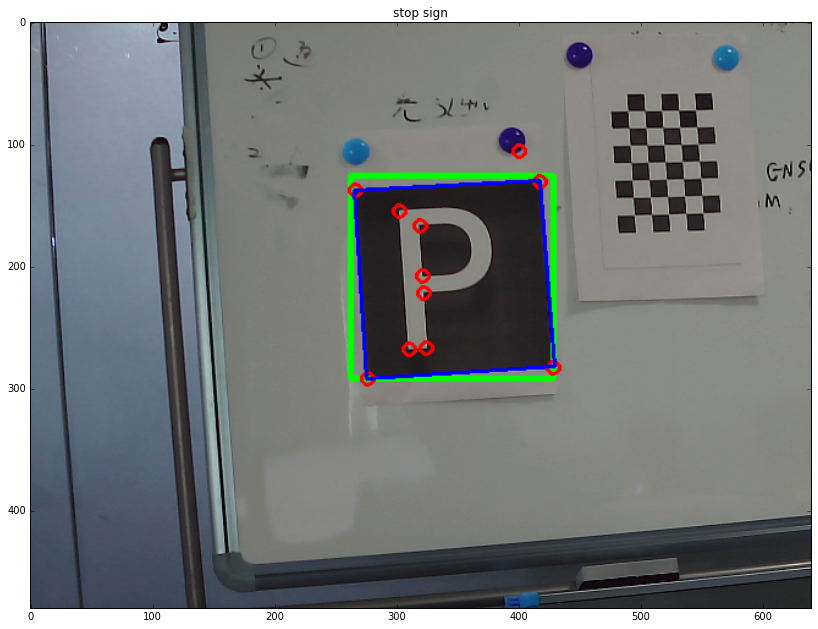

In [4]:
# detect edge by Canny operator
# with 100 lower bound and 200 higher bound
edge = cv2.Canny(rect,100,200)
plt.figure(figsize=(14,14))
plt.imshow(edge)
plt.title('canny edge')   

_,contours, hierarchy = cv2.findContours(edge,cv2.RETR_EXTERNAL,
                                         cv2.CHAIN_APPROX_SIMPLE)
best_cnt = [] # to store best contour
for cnt in contours:
    cnt = cv2.approxPolyDP(cnt, 0.02*len(cnt), True)
    if len(cnt)==4 and cv2.contourArea(cnt)>1000:
        best_cnt=cnt[:,0,:]
if best_cnt!=[]:
    print 'Found the boundary'
    for i in range(4):
        ix1 = best_cnt[i,0]
        iy1 = best_cnt[i,1]
        ix2 = best_cnt[(i+1)%4,0]
        iy2 = best_cnt[(i+1)%4,1]
        cv2.line(roi,(ix1,iy1),(ix2,iy2),(0,0,255),2)
plt.figure(figsize=(14,14))
plt.imshow(img)
plt.title('stop sign')        

id:0 is out of contour
remove id0
id:1 is overlapped
id:1 is out of contour
remove id1
id:2 is overlapped
id:2 is out of contour
remove id2
id:9 is overlapped
id:9 is out of contour
remove id9
id:10 is overlapped
id:10 is out of contour
remove id10
Keep 6 key points


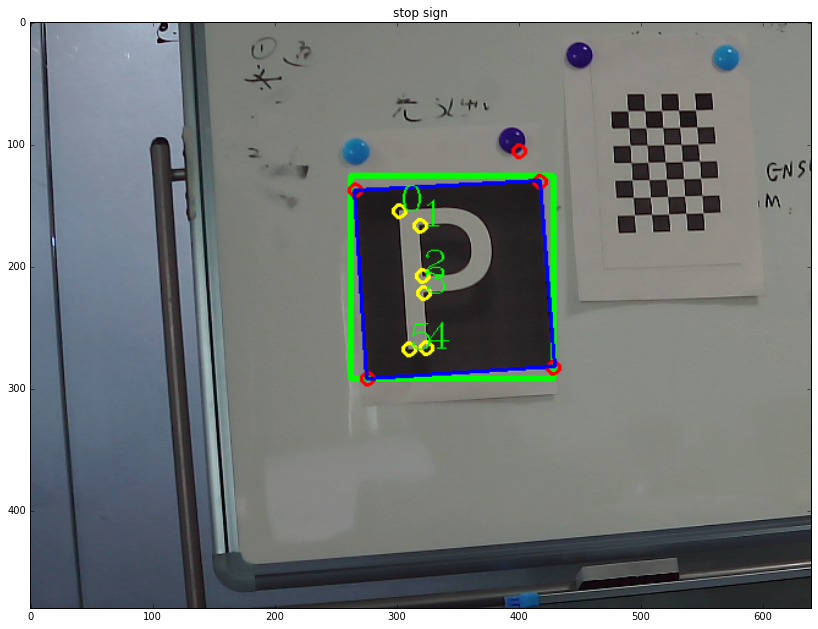

In [5]:
# calculate the angle between p0_p1 and p2_p1
def angle_cos(p0, p1, p2):
    d1, d2 = (p0-p1).astype('float'), (p2-p1).astype('float')
    return np.dot(d1, d2) / np.sqrt( np.dot(d1, d1)*np.dot(d2, d2) ) 

cid=0
rid=0
l = len(corners)
for tmp in range(l):
    corner=corners[cid]
    pts=(corner[0]-x+expend,corner[1]-y+expend)
    remove=False
    angle =[]
    for i in range(4):
        angle.append(angle_cos(pts, best_cnt[i], 
                                best_cnt[(i+1) % 4] ))
        if np.linalg.norm(mat(pts)-mat(best_cnt[i]))<5:
            
            remove=True
            print("id:%d is overlapped"%rid)
    min_cos = np.min(angle)
    if min_cos<0.1:
        remove=True
        print("id:%d is out of contour"%rid)
    if remove:
        del corners[cid]
        print('remove id%d' %rid)
        cid-=1
        
    else:
        cv2.circle(img,corner,5,(255,255,0),2)
        cv2.putText(img, '%d'%cid,corner,cv2.FONT_HERSHEY_COMPLEX,1,(0,255,0),1)           
    cid+=1  
    rid+=1
print ("Keep %d key points" %len(corners))
plt.figure(figsize=(14,14))
plt.imshow(img)
plt.title('stop sign')        

                                
                        

In [6]:
# world points ordinates
objp2 = np.float32([[0,0,0],[18,21,0],[74,21,0],[91,21,0],[151,21,0],[151,0,0]])
# termination criteria
square_size = 1
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, square_size, 0.001)
# load camera calibration result
with np.load('/home/shishu/work/vscode/Camera_calibration/point2.npz') as X:
# with np.load('point2.npz') as X:
    # print(X)
    mtx, dist= [X[i] for i in ('mtx','dist')]
print ("Camera matrix=",mtx,'distortion=',dist)

('Camera matrix=', array([[  2.07827057e+03,   0.00000000e+00,   2.67086552e+02],
       [  0.00000000e+00,   2.04387247e+03,   2.36396059e+02],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]]), 'distortion=', array([[ -4.84138224e-01,   3.35775606e-01,   4.00373267e-03,
          4.66206308e-02,  -1.22522913e+02]]))


In [7]:
# calculate worldpoints from image points
def img2worldpoint(imgpts,rvec,tvec,mtx):

    pts = np.ones((1,3),np.float32)
    pts[0,0]=imgpts[0]
    pts[0,1]=imgpts[1]
    pts[0,2]=1
    X = mat(pts)

    # convert rotation vector to rotaion matrix
    rmtx, jab = cv2.Rodrigues(rvec)

    R = mat(rmtx).T
    t = mat(tvec)
    K = mat(mtx).T

    Rt = np.ones((3,4),np.float32)
    Rt[:,0]=R[0,:]
    Rt[:,1]=R[1,:]
    Rt[:,2]=R[2,:]
    Rt[:,3]=t.T
    tform = K*Rt

    U = np.ones((4,1),np.float32)
    try:
        U = tform.I * X.T
    except:
        pass
    # U = (K*R).I * (X.T-K*t)

    wpts = np.zeros((3,1),np.float32)
    wpts[0] = U[0]/U[3]
    wpts[1] = U[1]/U[3]
    wpts[2] = U[2]/U[3]


    ori = R.T
    locat = -t.T*ori
    return wpts, locat, R, t, K

# find corners position in subpixel
corners2 = cv2.cornerSubPix(gray,np.float32(corners),(11,11),(-1,-1),criteria)

ret2, rvecs, tvecs, inliers = cv2.solvePnPRansac(objp2, corners2, mtx, dist)
worldPoints = np.zeros((3,1),np.float32)
worldPoints, locat, _, _, _ = img2worldpoint(corners[0], 
        rvecs, tvecs*square_size, mtx)
disToCam = np.linalg.norm(worldPoints.T-locat)
print ("distance to camera is %2f mm" %disToCam)

distance to camera is 2708.878519 mm
